In [71]:
window = 2
number_of_documents = 1

In [72]:
import urllib
from bs4 import BeautifulSoup

In [73]:
web_page = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"

In [74]:
import requests 
import re

In [75]:
response = requests.get(web_page)

In [76]:
soup_obj = BeautifulSoup(response.text,'lxml')

In [77]:
links_nonprepared = soup_obj.find_all('a', href=re.compile('yellow_tripdata'))

In [78]:
links = []
for link in links_nonprepared:
    links.append(link.attrs['href'])

In [79]:
import csv
from contextlib import closing
import codecs

In [80]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re, datetime

In [81]:
data = defaultdict(dict)

In [82]:
import matplotlib.pyplot as plt
%matplotlib notebook
plt.rcParams['animation.html'] = 'jshtml'

In [83]:
class RollingMean():
    def __init__(self, window, dict):
        self.dict = {} 
        self.window = window
        self.rolling_mean_results = []
        self.x = []
        self.y = []
        
 
    def handler(self,row_date,row_value):
        if row_date not in self.dict:
            self.dict[row_date]= {'km'    : row_value, 'N': 1, 'mean' : row_value} 
        else:
            self.dict[row_date]= { 'km'   : self.dict[row_date]['km'] + row_value,
                                    'N'   : self.dict[row_date]['N']  + 1,
                                   'mean' : self.mean(row_value,
                                                      self.dict[row_date]['N'],
                                                      self.dict[row_date]['mean'])} 
                
    def mean(self,new_sample, N, mean):
        mean -= mean / N;
        mean += new_sample / N;
        return mean;
    
    def rolling_mean(self,keys):
        self.mean_helper = self.dict[keys[0]]['mean']
        if self.window > len(keys):
            return
        
        if self.window < len(keys):
            for key in keys[:self.window]:
                self.mean_helper = self.mean(self.dict[key]['mean'],
                                             len(self.rolling_mean_results) + 1,
                                             self.mean_helper)
                
            self.rolling_mean_results.append([keys[:self.window],self.mean_helper])
        self.rolling_mean(keys[1:])
            
    def process_data(self,row,input_date):
        date = row[1].rsplit(" ",1)[0]
        match = re.search('\d{4}-\d{2}', date)
        given_date = datetime.datetime.strptime(match.group(), '%Y-%m').date() 
        if given_date == input_date:
            self.handler(date, float(row[4]))
        else:
            return  
        
                   
    def plot(self,x_axis,y_axis,i ):
        ax.plot(x_axis, y_axis, color='b')
        ax.set_title("Rolling mean")
        ax.set_xlabel("Window index")
        ax.set_ylabel("Mean by the window")
        fig.canvas.draw()
        ax.set_xlim(left=max(0, i-50), right=i+50)
 

In [84]:
obj = RollingMean(window, data)

In [85]:
for ix, link in enumerate(links):
    match = re.search('\d{4}-\d{2}', link)
    input_date = datetime.datetime.strptime(match.group(), '%Y-%m').date()
    with closing(requests.get(link, stream=True)) as r:
        reader = csv.reader(codecs.iterdecode(r.iter_lines(),'utf-8') )
        for row in reader:
            if row and ('trip_distance' not in row):
                  obj.process_data(row,input_date) 
    if ix == number_of_documents-1:
        break

In [86]:
keys = list(obj.dict.keys())
keys.sort()
obj.rolling_mean(keys)

In [87]:
temp_list = [i[1] for i in obj.rolling_mean_results]

<IPython.core.display.Javascript object>


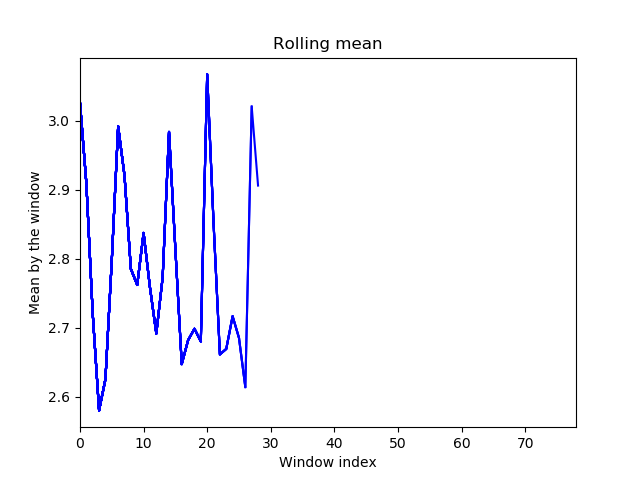

In [88]:
fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

In [89]:
x = []
y = []
for i,j in enumerate(temp_list):
    x.append(i)
    y.append(j)
    obj.plot(x,y,i)